In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
import time
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Set a mudafuggin seed
# random.seed(0)

class Point: 
    def __init__(self, type):
        self.type = type
        self.coordinates = np.array([0, 0])
        self.radius = 0.2

    def create_target(self):
        x = random.uniform(-3.0, 3.0)
        y = random.uniform(-2.0, 2.0)
        self.coordinates = np.array([x, y])
        self.theta = 0
        return self.coordinates, self.theta
    
    def create_defense(self, target):
        x = random.uniform((target.coordinates[0] - self.radius) - 1.5, (target.coordinates[0] + self.radius) + 1.5)
        y = random.uniform((target.coordinates[1] - self.radius) - 1.5, (target.coordinates[1] + self.radius) + 1.5)
        self.coordinates = np.array([x, y])
        return self.coordinates
    
    def create_attack(self, target):
        x_side_left = random.uniform(-9.5, (target.coordinates[0] - self.radius) - 2)
        x_side_right = random.uniform((target.coordinates[0] + self.radius) + 2, 9.5)
        y_below = random.uniform((target.coordinates[1] - self.radius) - 2, -9.5)
        y_above = random.uniform((target.coordinates[1] + self.radius) + 2, 9.5)
        x_inclusive = random.uniform(-9.5, 9.5)
        y_inclusive = random.uniform(-9.5, 9.5)
        y_below_x_inclusive = np.array([x_inclusive, y_below])
        y_above_x_inclusive = np.array([x_inclusive, y_above])
        x_left_y_inclusive = np.array([x_side_left, y_inclusive])
        x_right_y_inclusive = np.array([x_side_right, y_inclusive])

        self.coordinates = random.choice([y_below_x_inclusive, y_above_x_inclusive, x_left_y_inclusive, x_right_y_inclusive])
        
        # Create attack_theta
        self.AT_abs_length = math.hypot(self.coordinates[0] - target.coordinates[0], self.coordinates[1] - target.coordinates[1])
        self.length_adjacent_r = abs(target.coordinates[0] - self.coordinates[0])
        self.attack_theta_rad = math.acos(self.length_adjacent_r / self.AT_abs_length)

        if self.coordinates[0] < target.coordinates[0]:
            if self.coordinates[1] < target.coordinates[1]:
                self.attack_theta_rad = self.attack_theta_rad
            else:
                self.attack_theta_rad = ((2 * math.pi) - self.attack_theta_rad)
            
        else:
            if self.coordinates[1] < target.coordinates[1]:
                self.attack_theta_rad = ((math.pi) - self.attack_theta_rad)
            else:
                self.attack_theta_rad = ((math.pi) + self.attack_theta_rad)

        return self.coordinates, self.attack_theta_rad

class Missile:
    def __init__(self, type):
        self.type = type
        self.coordinates = np.array([0, 0])
        self.radius = 0.2
    
    def create_attack_missile(self, attack):
        self.speed = 1
        self.theta = attack.attack_theta_rad
        self.coordinates = attack.coordinates
        self.fired = False
        return self.coordinates, self.theta, self.speed, self.fired
    
    def fire_attack_missile(self, global_time):
        self.fired = True
        self.fired_time = global_time
        return self.fired, self.fired_time
    
    def fire_defense_missile(self, global_time):
        self.fired = True
        self.fired_time = global_time
        self.initial_position = np.array([self.coordinates[0], self.coordinates[1]])
        return self.fired, self.fired_time
    
    def create_defense_missile(self, defense, global_time, theta):
        self.speed = 1
        self.theta = theta
        self.coordinates = defense.coordinates
        self.fired = False
        self.fired_time = 0 
        self.defense_missile_to_attack_missile = None
        self.start_distance = None
        self.reward_diff = None

class Environment:
    def __init__(self):
        self.global_time = 0
        self.reward = 0

        self.target = None
        self.defense = None
        self.attack = None
        self.attack_missile = None
        self.armed_defense_missiles = []
        self.fired_defense_missiles = []

        self.attack_missile_to_target = None

    def set_episode(self, global_time):
        self.reward = 0
        self.target = Point('target')
        self.defense = Point('defense')
        self.attack = Point('attack')

        self.target.create_target()
        self.defense.create_defense(self.target)
        self.attack.create_attack(self.target)

        self.attack_missile = Missile('attack')
        self.attack_missile.create_attack_missile(self.attack)
        self.attack_missile.fire_attack_missile(global_time)
        self.attack_missile_to_target = self.distance_attack_to_target(self.attack_missile)

        self.armed_defense_missiles = []
        self.fired_defense_missiles = []

    def retry_episode(self):
        self.reward = 0
        self.global_time = 0
        self.armed_defense_missiles = []
        self.fired_defense_missiles = []

    def calculate_distance(self, point1, point2):
        return math.hypot(point1[0] - point2[0], point1[1] - point2[1])
    
    def distance_attack_to_target(self, attack_missile):
        self.attack_missile_to_target = (self.calculate_distance(attack_missile.coordinates, self.target.coordinates) - (attack_missile.radius + self.target.radius))
        return self.attack_missile_to_target
    
    def indv_distance_defense_to_attack(self, missile, attack_missile):
        missile.defense_missile_to_attack_missile = (self.calculate_distance(missile.coordinates, attack_missile.coordinates) - (missile.radius + attack_missile.radius))
        return missile.defense_missile_to_attack_missile

    def distance_defense_to_attack(self, attack_missile):
        for missile in self.fired_defense_missiles:
            missile.defense_missile_to_attack_missile = (self.calculate_distance(missile.coordinates, attack_missile.coordinates) - (missile.radius + attack_missile.radius))

    def local_create_defense_missile(self, defense, global_time, armed_defense_missiles, theta):
        defense_missile = Missile('defense')
        defense_missile.create_defense_missile(defense, global_time, theta)
        self.armed_defense_missiles.append(defense_missile)
        return defense_missile
    
    def local_fire_defense_missile(self, defense_missile, global_time, fired_defense_missiles, armed_defense_missiles):
        defense_missile.fire_defense_missile(global_time)
        fired_defense_missiles.append(defense_missile)
        armed_defense_missiles.remove(defense_missile)
        return defense_missile

    def update_attack_missile_position(self, attack_missile):
        new_coordx = self.attack.coordinates[0] + self.attack_missile.speed * self.global_time * math.cos(self.attack_missile.theta)
        new_coordy = self.attack.coordinates[1] + self.attack_missile.speed * self.global_time * math.sin(self.attack_missile.theta)
        attack_missile.coordinates = np.array([new_coordx, new_coordy])
        self.attack_missile.coordinates = np.array([new_coordx, new_coordy])
    
    def update_defense_missile_positions(self):
        for missile in self.fired_defense_missiles:
            new_coordx = missile.initial_position[0] + missile.speed * (self.global_time - missile.fired_time) * math.cos(missile.theta)
            new_coordy = missile.initial_position[1] + missile.speed * (self.global_time - missile.fired_time) * math.sin(missile.theta)
            missile.coordinates = np.array([new_coordx, new_coordy])

    def distance_reward(self):
        if len(self.fired_defense_missiles) > 0:
            payment_ponderations = [1, 0.9, 0.85, 0.75, 0.65, 0.55, 0.35, 0.25, 0.15, 0.05]
            max_index = len(payment_ponderations) - 1

            for i, missile in enumerate(self.fired_defense_missiles):
                missile.reward_diff = missile.start_distance - missile.defense_missile_to_attack_missile

                if missile.reward_diff > 0:
                    ponderation = payment_ponderations[i] if i <= max_index else 0
                    missile.reward_diff *= ponderation

                self.reward += missile.reward_diff 
        else:
            self.reward =+ 0

    def check_impact(self):
        for missile in self.fired_defense_missiles:
            if missile.defense_missile_to_attack_missile < 0:
                return 1000, True
            
        if self.attack_missile_to_target < 0:
            return -1000, True
 
        return 0, False

    def get_state(self):

        base_state = np.array(
            [
                self.global_time,
                self.reward,
                self.target.coordinates[0],
                self.target.coordinates[1],
                self.defense.coordinates[0],
                self.defense.coordinates[1],
                self.attack.coordinates[0],
                self.attack.coordinates[1],
                self.attack_missile.coordinates[0],
                self.attack_missile.coordinates[1],
                self.attack_missile.theta,
                self.attack_missile_to_target
            ]
        )

        for missile in self.fired_defense_missiles:
            fired_missile_state = np.array(
                [
                    1, # To represent creation (0: not created, 1: created)
                    missile.fired * 1, # Multiplication to convert boolean to int
                    missile.coordinates[0],
                    missile.coordinates[1],
                    missile.theta,
                    missile.fired_time,
                    self.global_time - missile.fired_time,
                    missile.start_distance,
                    missile.defense_missile_to_attack_missile,
                    missile.reward_diff
                ]
            )

            base_state = np.concatenate((base_state, fired_missile_state))
        
        for missile in self.armed_defense_missiles:
            armed_missile_state = np.array(
                [
                    1, 
                    missile.fired * 1,
                    missile.coordinates[0],
                    missile.coordinates[1],
                    missile.theta,
                    -9999, #fired_time won't make sense (as 0)
                    -9999, #global_time - fired_time won't make sense (as 0)
                    -9999, #start_distance might be needed
                    missile.defense_missile_to_attack_missile, #defense_missile_to_attack_missile might be needed
                    0  #reward as 0 is fine
                ]
            )
        
            base_state = np.concatenate((base_state, armed_missile_state))

        empty_missile = np.array([
            0,
            -9999,
            -9999,
            -9999,
            -9999, 
            -9999,
            -9999,
            -9999,
            -9999,
            0
        ])

        empty_missiles = np.tile(empty_missile, (15 - (len(self.armed_defense_missiles) + len(self.fired_defense_missiles))))
        base_state = np.concatenate((base_state, empty_missiles))

        return base_state        

    def step(self, action):
        create_missile, fire_now = action
        create_missile_condition, theta = create_missile

        self.update_attack_missile_position(self.attack_missile)
        self.distance_attack_to_target(self.attack_missile)

        if create_missile_condition and (len(self.armed_defense_missiles) + len(self.fired_defense_missiles)) < 15:
            self.local_create_defense_missile(self.defense, self.global_time, self.armed_defense_missiles, theta)
            self.distance_defense_to_attack(self.attack_missile)

        if fire_now:
            self.local_fire_defense_missile(self.armed_defense_missiles[0], self.global_time, self.fired_defense_missiles, self.armed_defense_missiles)
            self.fired_defense_missiles[-1].start_distance = self.indv_distance_defense_to_attack(self.fired_defense_missiles[-1], self.attack_missile)
            
        if len(self.fired_defense_missiles) > 0:
            self.update_defense_missile_positions()
            self.distance_defense_to_attack(self.attack_missile)

        if len(self.armed_defense_missiles) > 0:
            for missile in self.armed_defense_missiles:
                missile.defense_missile_to_attack_missile = self.indv_distance_defense_to_attack(missile, self.attack_missile)

        self.distance_reward()
        impact_reward, done = self.check_impact()
        self.reward += impact_reward

        self.global_time += 0.2

        state = self.get_state()

        return self.reward, done, state
    
    def debugger(self, episode_log, episodes):
        for i, episode in enumerate(episodes):
            print("\n--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/-")
            print("DEBUGGING EPISODE", episodes[i])
            print("-------------------------------------------------------------------")
            print("INITIAL CONDITIONS")
            print("global_time:", time = 0)
            print("Starting Attack Coordinates:", episode_log[episodes[i]][0])
            print("Starting Defense Coordinates:", episode_log[episodes[i]][1])
            print("Starting Target Coordinates:", episode_log[episodes[i]][2])

            
        print("\n--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/-")
        print("INITIAL CONDITIONS")
    
    def debugging_get_state(self, steps):
        print("\n--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/-")
        print("Environment created.")
        print("-------------------------------------------------------------------")
        print("INITIAL CONDITIONS")
        print("global_time:", self.global_time)
        print("Reward:", self.reward)
        print("Target coordinates:", self.target.coordinates)
        print("Defense coordinates:", self.defense.coordinates)
        print("Attack coordinates:", self.attack.coordinates)
        print("-------------------------------------------------------------------")
        print("ATTACK MISSILE")
        print("Attack Missile Fired:", self.attack_missile.fired)
        print("Attack Missile Coordinates:", self.attack_missile.coordinates)
        print("Attack Missile Theta:", self.attack_missile.theta)
        print("Attack Missile Speed:", self.attack_missile.speed)
        print("Attack Missile Fired Time:", self.attack_missile.fired_time)
        print("Attack Missile to Target:", self.attack_missile_to_target)
        print("-------------------------------------------------------------------")
        print("DEFENSE MISSILES")
        if len(self.armed_defense_missiles) > 0:
            i = 0
            for missile in self.defense_missiles:
                print("Defense Missile", i)
        else:
            print("No defense missiles created.")
        print("-------------------------------------------------------------------")
        print("\n")
        # print("--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/-\n")

        step_num = 1
        for step in steps:
            print("\n--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/-")
            print("STEP", step_num)
            print("Before: Environment recieved to make step")
            print("global_time:", self.global_time)
            print("Attack Missile Coordinates:", self.attack_missile.coordinates)
            print("Reward:", self.reward)
            print("-------------------------------------------------------------------")
            print("STEP (step function called)")
            self.step(step)
            print(f"Step = Create a missile: {step[0][0]}, theta: {step[0][1]}, fire_now: {step[1]}")
            print("-------------------------------------------------------------------")
            print("AFTER STEP: Environment after step")
            print("global_time:", self.global_time)
            print("Attack Missile Coordinates:", self.attack_missile.coordinates)
            print("Reward:", self.reward)
            print("-------------------------------------------------------------------")
            print("DEFENSE MISSILES")
            print("...................................................................")
            print("ARMED MISSILES")
            print("Armed Defense Missiles Count:", len(self.armed_defense_missiles))
            print("Armed Defense Missiles:", self.armed_defense_missiles)

            j = 1 
            for missile in self.armed_defense_missiles:
                print("\n#################")
                print("(ARMED) Defense Missile", j)
                print("Defense Missile Corrdinates:", missile.coordinates)
                print("Defense Missile Theta:", missile.theta)
                print("Defense Missile Fired:", missile.fired)
                print("Defense Missile Fired Time:", missile.fired_time)
                print("Global Time:", self.global_time)
                print("Fired Time:", missile.fired_time)
                print("Global Time - Fired Time:", self.global_time - missile.fired_time)
                print("Defense Missile to Attack Missile:", missile.defense_missile_to_attack_missile)
                print("Defense Missile Start Distance:", missile.start_distance)
                print("Reward Difference:", missile.reward_diff)
                print("#################\n")

                j += 1

            i = 1
            for missile in self.fired_defense_missiles:
                print("\n~~~~~~~~~~~~~~~~~")
                print("(FIRED) Defense Missile", i)
                print("Defense Missile Corrdinates:", missile.coordinates)
                print("Defense Missile Theta:", missile.theta)
                print("Defense Missile Fired:", missile.fired)
                print("Defense Missile Fired Time:", missile.fired_time)
                print("Global Time:", self.global_time)
                print("Fired Time:", missile.fired_time)
                print("Global Time - Fired Time:", self.global_time - missile.fired_time)
                print("Defense Missile to Attack Missile:", missile.defense_missile_to_attack_missile)
                print("Defense Missile Start Distance:", missile.start_distance)
                print("Reward Difference:", missile.reward_diff)
                i += 1
                print("~~~~~~~~~~~~~~~~~\n")

            print("-------------------------------------------------------------------")
            print("IMPACT CHECK & SUMMARY")
            print("Attack Coordinates:", self.attack.coordinates)
            print("Target Coordinates:", self.target.coordinates)
            print("Defense Coordinates:", self.defense.coordinates)
            print("Attack Missile to Target:", self.attack_missile_to_target)
            print("Reward:", self.reward)
            print("Impact Check:", self.check_impact())
            print("--")
            print("Attack Missile Coordinates:", self.attack_missile.coordinates)
            print("Attack distance to target:", self.attack_missile_to_target)
            print("--")
            i = 1
            for missile in self.armed_defense_missiles:
                print("(ARMED) Defense Missile No.:", i)
                print("Defense Missile Coordinates:", missile.coordinates)
                print("Defense Missile to Attack Missile:", missile.defense_missile_to_attack_missile)
                print("Reward Difference:", missile.reward_diff)
                print("--")
                i += 1
            j = 1
            for missile in self.fired_defense_missiles:
                print("(FIRED) Defense Missile No.:", j)
                print("Defense Missile Coordinates:", missile.coordinates)
                print("Defense Missile to Attack Missile:", missile.defense_missile_to_attack_missile)
                print("Reward Difference:", missile.reward_diff)
                print("--")
                j += 1

            print("--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/-\n")
            step_num += 1


In [3]:
env = Environment()
env.set_episode(env.global_time)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_model(input_dim):
    model = Sequential([
        Dense(128, input_shape=(input_dim,), activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(2, activation='linear')  # Output layer: Assuming 2 actions (create missile and fire missile)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Assuming your state vector length from get_state() method
input_dim = len(env.get_state())
model = build_model(input_dim)

def choose_action(state, model, epsilon):
    if np.random.rand() <= epsilon:
        create_missile = (np.random.randint(2), np.random.uniform(0, 2*np.pi)) if np.random.rand() > 0.5 else (0, None)
        fire_now = np.random.randint(2) if len(env.armed_defense_missiles) > 0 else 0
    else:
        q_values = model.predict(state.reshape(1, -1))
        create_missile = (1, np.random.uniform(0, 2*np.pi)) if q_values[0][0] > 0.5 else (0, None)
        fire_now = 1 if q_values[0][1] > 0.5 and len(env.armed_defense_missiles) > 0 else 0

    return (create_missile, fire_now)    

-----------------------------------------------
Starting new episode
-----------------------------------------------
env.global_time: 0
starting target coordinates: [ 0.7966312  -1.66932437]
starting defense coordinates: [ 0.32282421 -2.63991377]
starting attack coordinates: [ 4.36374652 -3.75925123]
starting attack missile coordinates: [ 4.36374652 -3.75925123]
-----------------------------------------------
Global_time: 0.00
action:  ((0, 0.05353857084457549), 0)
Attack Missile Coordinates: [ 4.36374652 -3.75925123]
Reward: 0.00
 Distance to Target: 3.73
1/1 [==============================] - 0s 40ms/step
Global_time: 0.20
action:  ((0, 5.161350100985074), 0)
Attack Missile Coordinates: [ 4.19118285 -3.65814841]
Reward: 0.00
 Distance to Target: 3.53
1/1 [==============================] - 0s 42ms/step
Global_time: 0.40
action:  ((0, None), 0)
Attack Missile Coordinates: [ 4.01861919 -3.55704558]
Reward: 0.00
 Distance to Target: 3.33
1/1 [==============================] - 0s 48ms/ste

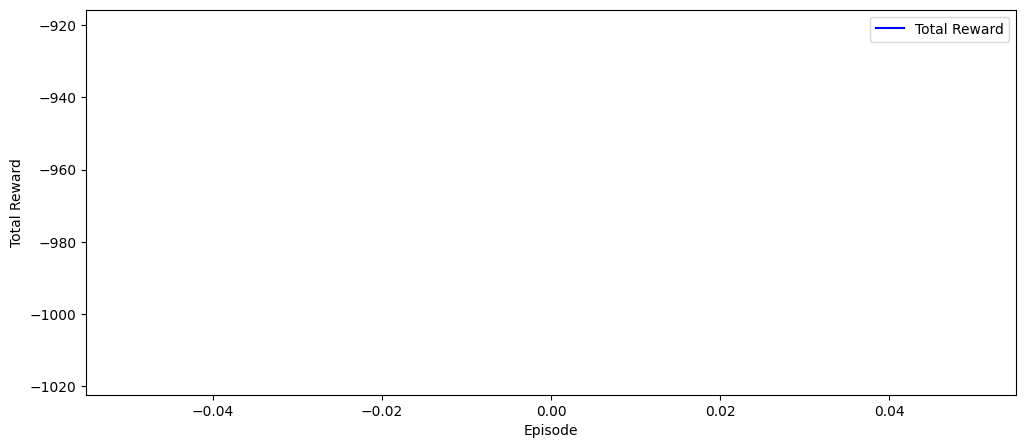

Episode 1/500, Total Reward: -969.0423949398155, Epsilon: 0.9801888648295347
-----------------------------------------------
Starting new episode
-----------------------------------------------
env.global_time: 0
starting target coordinates: [-0.95954544 -0.3996894 ]
starting defense coordinates: [-2.22940901  1.21317388]
starting attack coordinates: [-3.59898286 -8.35320599]
starting attack missile coordinates: [-3.59898286 -8.35320599]
-----------------------------------------------
Global_time: 0.00
action:  ((0, None), 0)
Attack Missile Coordinates: [-3.59898286 -8.35320599]
Reward: 0.00
 Distance to Target: 7.98
1/1 [==============================] - 0s 19ms/step
Global_time: 0.20
action:  ((0, 4.031305860799925), 0)
Attack Missile Coordinates: [-3.53598942 -8.16338548]
Reward: 0.00
 Distance to Target: 7.78
1/1 [==============================] - 0s 32ms/step
Global_time: 0.40
action:  ((1, 4.1779340765916295), 0)
Attack Missile Coordinates: [-3.47299598 -7.97356496]
Reward: 0.00


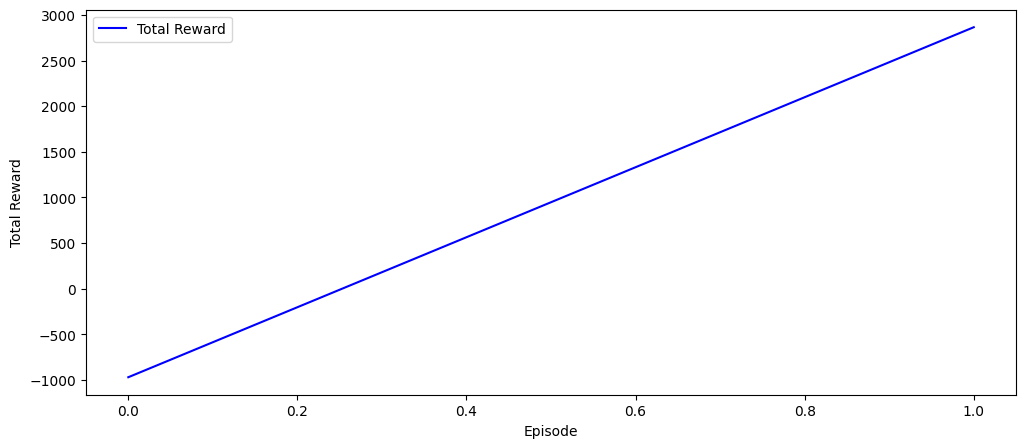

Episode 2/500, Total Reward: 2864.723727073179, Epsilon: 0.9407945259609451
-----------------------------------------------
Starting new episode
-----------------------------------------------
env.global_time: 0
starting target coordinates: [-2.82969026  0.59984833]
starting defense coordinates: [-3.15502256  0.9964628 ]
starting attack coordinates: [-2.00914211  5.7121947 ]
starting attack missile coordinates: [-2.00914211  5.7121947 ]
-----------------------------------------------
Global_time: 0.00
action:  ((0, None), 0)
Attack Missile Coordinates: [-2.00914211  5.7121947 ]
Reward: 0.00
 Distance to Target: 4.78
1/1 [==============================] - 0s 20ms/step
Global_time: 0.20
action:  ((0, None), 0)
Attack Missile Coordinates: [-2.04083711  5.5147221 ]
Reward: 0.00
 Distance to Target: 4.58
1/1 [==============================] - 0s 23ms/step
Global_time: 0.40
action:  ((1, 1.4451661270793983), 0)
Attack Missile Coordinates: [-2.0725321  5.3172495]
Reward: 0.00
 Distance to Tar

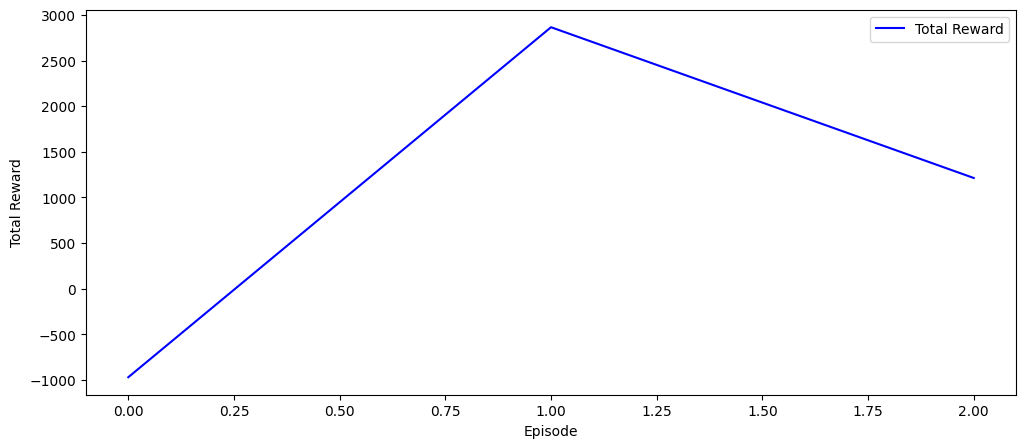

Episode 3/500, Total Reward: 1213.3117150458925, Epsilon: 0.9249283295681431
-----------------------------------------------
Starting new episode
-----------------------------------------------
env.global_time: 0
starting target coordinates: [ 2.11380604 -1.57522446]
starting defense coordinates: [ 2.18424497 -0.11252694]
starting attack coordinates: [-8.70060863  8.72410102]
starting attack missile coordinates: [-8.70060863  8.72410102]
-----------------------------------------------
Global_time: 0.00
action:  ((0, None), 0)
Attack Missile Coordinates: [-8.70060863  8.72410102]
Reward: 0.00
 Distance to Target: 14.53
1/1 [==============================] - 0s 21ms/step
Global_time: 0.20
1/1 [==============================] - 0s 32ms/step
action:  ((1, 0.6800292610601576), 0)
Attack Missile Coordinates: [-8.55578026  8.58617081]
Reward: 0.00
 Distance to Target: 14.33
1/1 [==============================] - 0s 18ms/step
Global_time: 0.40
1/1 [==============================] - 0s 17ms/ste

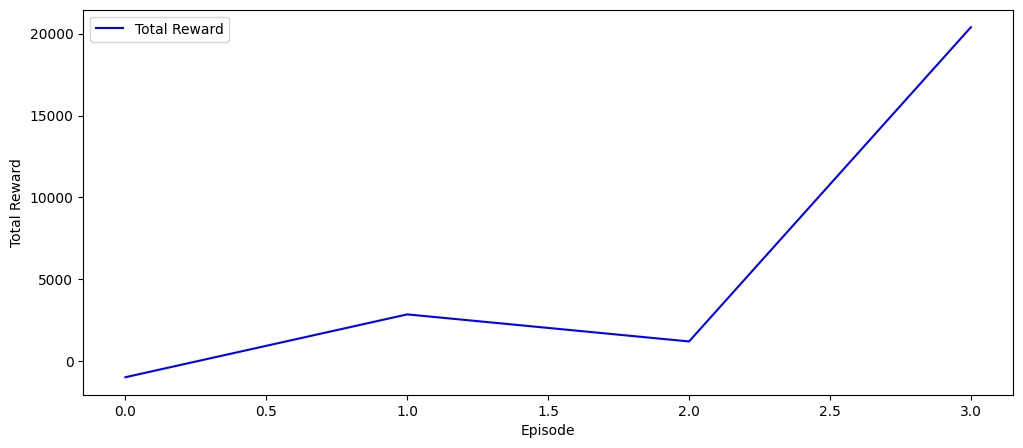

Episode 4/500, Total Reward: 20387.8547288019, Epsilon: 0.8745314299402548
-----------------------------------------------
Starting new episode
-----------------------------------------------
env.global_time: 0
starting target coordinates: [ 1.5278438  -1.77206862]
starting defense coordinates: [ 0.39893628 -2.09272663]
starting attack coordinates: [4.73376267 3.18973291]
starting attack missile coordinates: [4.73376267 3.18973291]
-----------------------------------------------
Global_time: 0.00
action:  ((0, None), 0)
Attack Missile Coordinates: [4.73376267 3.18973291]
Reward: 0.00
 Distance to Target: 5.51
1/1 [==============================] - 0s 21ms/step
Global_time: 0.20
action:  ((0, 5.739515741864079), 0)
Attack Missile Coordinates: [4.62522362 3.02174698]
Reward: 0.00
 Distance to Target: 5.31
1/1 [==============================] - 0s 19ms/step
Global_time: 0.40
action:  ((0, 0.7328681839090668), 0)
Attack Missile Coordinates: [4.51668456 2.85376105]
Reward: 0.00
 Distance to

KeyboardInterrupt: 

In [21]:
episode_logs = {}
print

def train_model(env, model, episodes, learning_rate=0.01, gamma=0.95, epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.01):
    rewards_list = []

    for episode in range(episodes):
        print("-----------------------------------------------")
        print("Starting new episode")

        env.global_time = 0
        done = False
        env.set_episode(env.global_time)
        print("-----------------------------------------------")
        print("env.global_time:", env.global_time)
        print("starting target coordinates:", env.target.coordinates)
        print("starting defense coordinates:", env.defense.coordinates)
        print("starting attack coordinates:", env.attack.coordinates)
        print("starting attack missile coordinates:", env.attack_missile.coordinates)        
        print("-----------------------------------------------")
        state = env.get_state()
        total_reward = 0

        initial_coords = [env.attack.coordinates, env.defense.coordinates, env.target.coordinates]
        actions_list = []
        
        while not done:
            # Print step number and global time
            print(f"Global_time: {env.global_time:.2f}")
            action = choose_action(state, model, epsilon)  # Assume this returns a properly structured action
            reward, done, next_state = env.step(action)
            total_reward += reward

            # Print the missile coordinates and the reward
            print("action: ", action)
            print(f"Attack Missile Coordinates: {env.attack_missile.coordinates}")
            print(f"Reward: {reward:.2f}")
            print(f" Distance to Target: {env.attack_missile_to_target:.2f}")

            actions_list.append(action)

            # Obtain the next action's max Q-value for the Bellman equation update
            next_q_values = model.predict(next_state.reshape(1, -1))
            max_next_q_value = np.max(next_q_values)  # Assume the model outputs separate Q-values for each action type

            # Get current Q-values, update the relevant action's Q-value
            current_q_values = model.predict(state.reshape(1, -1))
            current_q_values[0][np.argmax(next_q_values[0])] = reward + gamma * max_next_q_value

            # Fit the model
            model.fit(state.reshape(1, -1), current_q_values, epochs=1, verbose=0)

            state = next_state  # Update state

            # Decay epsilon
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

        episode_logs[episode] = initial_coords + actions_list
        rewards_list.append(total_reward) 
        
        #Plot some shii
        # clear_output(wait=True)
        plt.figure(figsize=(12, 5))
        plt.plot(rewards_list, color='b', label='Total Reward')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.legend()
        plt.show()
        
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon}")

env = Environment()  # Assume env is your environment instance
train_model(env, model, 500)  # Train for 500 episodes


In [23]:
print(episode_logs)
print(episode_logs[4])

{1: [array([ 4.36374652, -3.75925123]), array([ 0.32282421, -2.63991377]), array([ 0.7966312 , -1.66932437]), ((0, 0.05353857084457549), 0), ((0, 5.161350100985074), 0), ((0, None), 0), ((0, None), 0), ((0, None), 0), ((0, 0.830703538780432), 0), ((0, 5.66981133350414), 0), ((0, None), 0), ((0, 0.10988412936752201), 0), ((0, 5.777926242807247), 0), ((1, 1.0095485964238529), 0), ((1, 4.475737027107942), 1), ((1, 4.796503301817066), 1), ((1, 3.549732822308917), 0), ((0, None), 1), ((1, 1.7701607792247078), 1), ((0, 1.152948330426134), 0), ((1, 2.1768575946936535), 1), ((0, None), 1), ((1, 6.163156445009821), 0)], 2: [array([-3.59898286, -8.35320599]), array([-2.22940901,  1.21317388]), array([-0.95954544, -0.3996894 ]), ((0, None), 0), ((0, 4.031305860799925), 0), ((1, 4.1779340765916295), 0), ((0, None), 0), ((0, 5.482067914516869), 1), ((0, 2.2980438800375036), 0), ((0, None), 0), ((0, 2.5114768358219646), 0), ((1, 3.612697509068193), 0), ((1, 1.6817702661686624), 0), ((0, None), 0), (